## Notebook #5 goal

This notebook modifies the main model to integrate the NHPP and the variable stay code together

#### Very basic shelter model

This simpy model is Inspired by car wash example https://simpy.readthedocs.io/en/latest/examples/carwash.html

The parameters in this model are:
- the client is only 1 person 
    - *this need to make it random from 1-6)*
- the stay period of client is random, and between 7 days to 365
    - *this needs to be made into a distribution (or combination of distribution) based on any one of the four cases discussed [here](https://github.com/sim-team-z/learning-simpy/blob/main/README.md)*
- the number of beds in shelter are 35
- the clients arrive at the shelter seeking refuge every 7 days.
    - *this needs to be made variable, perhaps picking an RV from a poisson distribution*


This model also turn away clients when at capacity, and keeps count of the number.

In [1]:
import math
import numpy as np
import pandas as pd
import random
from scipy.stats import poisson
import matplotlib.pyplot as plt
import simpy
from datetime import datetime

In [66]:
##shelter model

RANDOM_SEED = 42 # not used
NUM_BEDS = 15  # Number of beds in the shelter
MAX_FAMILY_SIZE = 6 # maximum # of people in the client's family (mom and children)
CASE_DISTRIBUTION = [0.25, 0.25, 0.25, 0.25] # ratio of clients showing up [CAPABLE, CULTURAL CHALLENGES, MENTAL CHALLENGES, SKILLS GAP]
POISSON_ARRIVAL_JAN_AUG =  10 #a family every 10 days
POISSON_ARRIVAL_SEP_DEC = 5 #  a family every 5 days
#STAYTIME = random.randint(7, 365)      # days the initial clients stayed at shelter # NOT USED ANYMORE
#T_INTER = 7       # Create a client to arrive every ~7 days
SIM_TIME = 365*3     # Simulation time in days
referred_clients_count = 0 # number of clients turned away.


    
class Shelter(object):
    """A shelter has a limited number of beds (``NUM_BEDS``) to
    host clients.

    Clients have to request one of the beds. When they got one, they
    can start their stay (which takes ``staytime`` minutes).

    """
    referred_clients = 0
    day_of_year = 1
    
    #def __init__(self, env, num_beds, staytime):
    def __init__(self, env, num_beds):
        self.env = env
        self.shelter = simpy.Resource(env, num_beds)
        print('~~SIMULATION STARTUP~~ Shelter has {} beds available'.format(NUM_BEDS - self.shelter.count))
        #self.staytime = staytime
        self.referred_clients = 0
        self.data_table = pd.DataFrame({
            'run_number' : [],
            'day': [],
            'month' : [],
            'ppl_turned_away': [],
            'shelter_capacity_left': [],
            'client_case1': [],
            'client_case2': [],
            'client_case3': [],
            'client_case4': []
        })

    def append_shelter_data(self,data_array):
        df2 = pd.DataFrame({
        'run_number' : [data_array[0]],
        'day': [data_array[1]],
        'month' : [data_array[2]],
        'ppl_turned_away': [data_array[3]],
        'shelter_capacity_left': [data_array[4]],
        'client_case1': [data_array[5]],
        'client_case2': [data_array[6]],
        'client_case3': [data_array[7]],
        'client_case4': [data_array[8]]
                            })
        return pd.concat([self.data_table,df2])

    def get_count_of_referred_clients():
        return self.referred_clients
    
    def increment_count_of_referred_clients():
        self.referred_clients += 1
    
    def stay2(self, client_name, family_size, case):
        #simulates duration of stay for client (and family, if applicable)
        #based on her case (CAPABLE=1, CULTURAL=2, MENTAL=3, SKILLS=4)
        
        if case == 1 : # Capable and quickly back on their feet
            stay_duration = random.randint(7, 2*30)
        elif case == 2: #Language and cultural barrier
            stay_duration = random.randint(9*30, 12*30)
        elif case == 3: #Mental barrier
            stay_duration = random.randint(4*30, 9*30) # TODO this is a long tailed distribution, not uniform. check README.md.
            #need to change
        elif case == 4:
            stay_duration = random.randint(2*30, 6*30)
        
        return stay_duration
        
        

def month(day_num):
    # adjusting day num
    #day_num.rjust(3 + len(day_num), '0')
    # Initialize year
    year = "2022"
    # converting to date
    month = datetime.strptime(year + "-" + str(day_num), "%Y-%j").strftime("%m")
    return month
  

        

def number_of_days_next_client_turns_up(current_day):
    #passing it the shelter object since it is tracking the day_of_year for the simulation.
    #if the day is within first 8 months (Jan - Aug), the rate of clients coming in is slower 
    # than if its between 9-12th (Sept-Dec) months.
    # there should be an option in simpy to find the day of the simulation too
    # 242 days === January 1, 2022 - August 31, 2022
    #current_day = env.now
    #print("[number_of_days_next_client_turns_up], env.now is : {}".format(current_day))
    if current_day < 242:
        return poisson.rvs(POISSON_ARRIVAL_JAN_AUG)
    else:
        return poisson.rvs(POISSON_ARRIVAL_SEP_DEC)
            
def client_family_size():
    return random.randint(1, MAX_FAMILY_SIZE)

def client_case_type():
    caseList = [1,2,3,4]
    return random.choices(caseList, weights=CASE_DISTRIBUTION, k=1)[0]
    

def client(env, client_name, family_size, case_type, shelter_object):
    # The client process (each client has a client_name) arrives potentially 
    # with family (family_size) with a condition (case_type) at the shelter 
    # and requests bed(s).
    if (
        (NUM_BEDS - shelter_object.shelter.count == 0) or 
        (NUM_BEDS - shelter_object.shelter.count < family_size)):
        print("(day {})\t[client] !!!!SHELTER AT CAPACITY. only {} available beds. Referring out {} family of {} "
              .format(env.now,
                      NUM_BEDS - shelter_object.shelter.count,
                      client_name,
                      family_size))
        shelter_object.referred_clients += family_size
        referred_clients_count = shelter_object.referred_clients
        print("(day {})\t[client] Shelter has unfortunately turned {} clients (including their family members) away thus far."
              .format(env.now, shelter_object.referred_clients))
        
        
        # event! shelter just turned away people, write to the pandas data_table:
        #first , prepare case_array, (all zeros here)
        case_array = [0,0,0,0]
        data_array = [run_number,env.now+1,month(env.now+1),shelter_object.referred_clients,
            NUM_BEDS - shelter_object.shelter.count]
        
        #finally, append both data_array and case_array and shove that into the data_table.
        shelter_object.data_table = shelter_object.append_shelter_data(np.append(data_array,case_array))
        
        pd.set_option('expand_frame_repr', False)
        print(shelter_object.data_table)
        
    else:
        print('(day {})\t[client] {} (family size = {}, case type = {}) arrives the shelter\tavailable beds {}.'
              .format(env.now, client_name, 
                      family_size, 
                      case_type, 
                      NUM_BEDS - shelter_object.shelter.count))
        
        
        beds_taken = []

        for i in range(family_size):    
            beds_taken.append(shelter_object.shelter.request())
            print("(day {})\t[client] {}, family member {} went into shelter\tavailable_beds {}"
                  .format(env.now, client_name, i, NUM_BEDS - shelter_object.shelter.count))
        
        # event! client and family just went into shelter, write to the pandas data_table:
        #first , prepare case_array
        case_array = []
        
        if case_type == 1:
            case_array = [family_size,0,0,0]
        elif case_type == 2:
            case_array = [0,family_size,0,0]
        elif case_type == 3:
            case_array = [0,0,family_size,0]
        elif case_type == 4:
            case_array = [0,0,0,family_size]
        #second , prepare data_array
        data_array = [run_number,env.now+1,month(env.now+1),shelter_object.referred_clients,
            NUM_BEDS - shelter_object.shelter.count]
        
        #finally, append both data_array and case_array and shove that into the data_table.
        shelter_object.data_table = shelter_object.append_shelter_data(np.append(data_array,case_array))
        
        pd.set_option('expand_frame_repr', False)
        print(shelter_object.data_table)
            
        # the client and her family's stay starts:
        yield env.timeout(shelter_object.stay2(client_name,family_size,case_type))
        # the client's stay is complete
        
        for i in range(family_size):
            shelter_object.shelter.release(beds_taken[i])
            print("(day {})\t[client] {}, family member {} came out of shelter\tavailable_beds {}"
                  .format(env.now, client_name, i, NUM_BEDS - shelter_object.shelter.count))
        
        #event! the client and fam just left shelter, update data_table:
        #first, invert the case_array (as the peeps are leaving)
        case_array = -1*np.array(case_array)
        #second, create data_array:
        data_array = [run_number,env.now+1,month(env.now+1),shelter_object.referred_clients,
            NUM_BEDS - shelter_object.shelter.count]
        #finally, append both data_array and case_array and shove that into the data_table.
        shelter_object.data_table = shelter_object.append_shelter_data(np.append(data_array,case_array))
        
        pd.set_option('expand_frame_repr', False)
        print(shelter_object.data_table)
        
        
        print('(day {})\t[client] {} (family size = {}, case type = {}) LEAVES the shelter\tavailable beds {}'
              .format(env.now,
                      client_name, 
                      family_size, 
                      case_type, 
                      NUM_BEDS - shelter_object.shelter.count)
             )
        
        
def main(env, num_beds):
    

    # Create the shelter object
    shelter = Shelter(env, num_beds)

    # Create 4 initial clients
    for client_number in range(4):
        env.process(
            client(
                env, 
                'Client %d' % client_number, 
                client_family_size(), 
                client_case_type(), 
                shelter))

    # Create more clients while the simulation is running
    while True:
        # the following code calls a function which returns the number of days after which the next
        # client(+family) shows up
        yield env.timeout(number_of_days_next_client_turns_up(env.now))
        client_number += 1
        env.process(
            client(env, 
                   'Client %i' % client_number, 
                   client_family_size(), 
                   client_case_type(), 
                   shelter))
    
    

#~~~~~~~ MAIN...

main_data_table = pd.DataFrame({
        'run_number' : [],
        'day': [],
        'ppl_turned_away': [],
        'shelter_capacity_left': [],
        'client_case1': [],
        'client_case2': [],
        'client_case3': [],
        'client_case4': []
    })
# Setup and start the simulation
random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()

#env.process(setup(env, NUM_BEDS, STAYTIME, T_INTER))
env.process(main(env, NUM_BEDS))


# Execute!

env.run(until=SIM_TIME)






~~SIMULATION STARTUP~~ Shelter has 15 beds available
(day 0)	[client] Client 0 (family size = 6, case type = 1) arrives the shelter	available beds 15.
(day 0)	[client] Client 0, family member 0 went into shelter	available_beds 14
(day 0)	[client] Client 0, family member 1 went into shelter	available_beds 13
(day 0)	[client] Client 0, family member 2 went into shelter	available_beds 12
(day 0)	[client] Client 0, family member 3 went into shelter	available_beds 11
(day 0)	[client] Client 0, family member 4 went into shelter	available_beds 10
(day 0)	[client] Client 0, family member 5 went into shelter	available_beds 9
  run_number day month ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0          0   1    01               0                     9            6            0            0            0
(day 0)	[client] Client 1 (family size = 6, case type = 2) arrives the shelter	available beds 9.
(day 0)	[client] Client 1, family member 0 went into 

  run_number  day month ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0          0    1    01               0                     9            6            0            0            0
0          0    1    01               0                     3            0            6            0            0
0          0    1    01               0                     1            2            0            0            0
0          0    1    01               0                     0            0            0            1            0
0          0    9    01               1                     0            0            0            0            0
0          0   16    01               3                     0            0            0            0            0
0          0   30    01               8                     0            0            0            0            0
0          0   42    02               8                     6           -6            0 

ValueError: unconverted data remains: 8

In [22]:
data_table

,run_number,day,client_case1,client_case2,client_case3,client_case4,ppl_turned_away,shelter_capacity_left


#### References :
##### https://hpaulkeeler.com/simulating-an-inhomogeneous-poisson-point-process/
##### https://stackoverflow.com/questions/32712409/how-to-sample-inhomogeneous-poisson-processes-in-python-faster-than-this

In [74]:
## Lets assume the average number of entries in the shelter on non-holiday season is 20 and holiday season is 30
## Each entry could be between 1 to 4 women arriving at shelter

In [5]:
#defining non-homogenous poison process with arrival rates varying between 1 to 4 in the day
def nhpp_arrival():
    t = 0
    potential_arr_time = 0
    arrival_times = []
    arrival_rate = []

  #defining a period function where arrival rate varies from 1 to 4
    ld = 3.5 + 2.5*math.sin(t/2)
    
  #max_arrivals
    ld_0 = 6                 
  
    for month in range(1,12):
        if (month <= 8):
            n = 20
        else:
            n = 30
        
        #generates arrival for each month
        for i in range(0,n):
            ld = 3.5 + 2.5*math.sin(t/2)
            
            #generate a uniform sample
            U = random.uniform(0,1)
            
            #calculating exponential arrival time 
            potential_intr_arr = -1/ld_0 * math.log(U)  

            #bootstraping to get arrival times for each arrival
            potential_arr_time += potential_intr_arr 

            #assign the new arrival time to t
            t = potential_arr_time

            #generate a uniform to test the probability of accepting or rejecting the potential arrival (Thinning algorithm)
            V =  random.uniform(0,1)
            prob = ld / ld_0

       #accept t if V < prob
            if V <= prob:
                 arrival_times.append(t)
            i+=1
            
    for j in range(0,len(arrival_times)):
        x = 3.5 + 2.5*math.sin(arrival_times[j]/2)
        arrival_rate.append(x)
    
    #generate client type for each arrival 
    client_type = list(np.random.choice([1,2,3,4],len(arrival_times), p=[0.25,0.25,0.25,0.25]))
    
    return(arrival_times,arrival_rate,client_type)

In [12]:
# Arrivals on a weekday:
arrival_times,arrival_rate,client_type = nhpp_arrival()

# plotting the arrival rates at each arrival time ---> non-homogeneous poisson process
#plt.plot(arrival_times,arrival_rate, color='red', linestyle='dashed', linewidth = 2,
#         marker='o', markerfacecolor='blue', markersize=5 )
#plt.title('NHPP Arrivals for the year')

In [14]:
arrival_times

[0.31373334158239535,
 0.41787086182746713,
 0.7172429824951704,
 0.7654217729773358,
 0.9725345971104931,
 1.034698176101332,
 1.0445369068195118,
 1.1621426373989454,
 1.6992030192228813,
 1.8879039401780777,
 2.3166516435289783,
 2.391242306499893,
 2.9267590905681162,
 3.052418685604856,
 3.0670285947153326,
 3.1562919494523274,
 3.274597621196681,
 3.4505417399748515,
 3.517254793059231,
 3.702131086464478,
 3.9094708949233143,
 3.9438589252566105,
 4.0751656838742845,
 4.414359494663421,
 4.416351482293231,
 4.518250596341127,
 4.797173314619393,
 4.8436946299406145,
 4.889436179662379,
 5.126857545124104,
 5.56095710003805,
 5.86808537734965,
 5.967044024884175,
 6.097237213043412,
 6.127862341228213,
 6.183401146690134,
 6.4028480481694166,
 6.5021046318769224,
 6.515663476887634,
 7.221553656279574,
 7.429373773491504,
 7.532510133484939,
 7.762686399761611,
 8.133822961928505,
 8.176187953226055,
 9.223232675252348,
 9.86728813782743,
 12.275687054535862,
 12.860028737761162,

Text(0.5, 1.0, 'Histogram of arrivals')

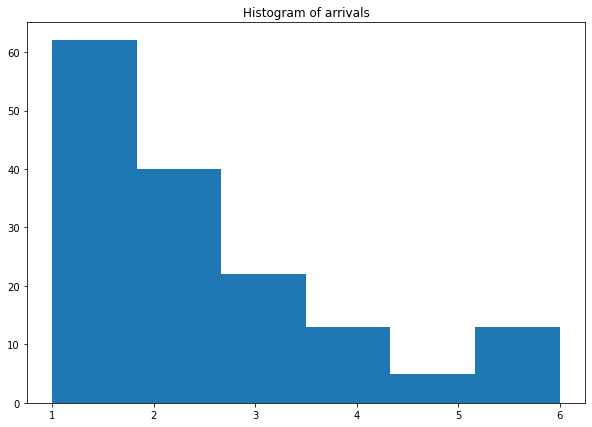

In [78]:
# round off arrivals
fig, ax = plt.subplots(figsize =(10, 7))
# mirror the arrivals to make it skewed for smaller arrivals compared to larger ones (can be removed if needed)
ax.hist([7-round(i) for i in arrival_rate],bins=6)
plt.title('Histogram of arrivals')